In [13]:
import torch
import torchvision
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import DataLoader

In [14]:
from dataset_utils import MNISTDataset

In [15]:
IMG_SIZE = 32
BATCH_SIZE = 60

MODEL = "diffusion_model_MNIST_ConvNext"
DATASET = "MNIST"

BLOCKS = "convNext" # 'convNext', 'res'
IMPROVED_DDPM = False
ADAPTIVE_GN = False 
USE_ATTENTION = True

### Checkpoint Saving Directory

In [16]:
### Creating a directory to save model checkpoints
import os

models_dir = "models_MNIST"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

### Dataset Loading

In [17]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMG_SIZE, IMG_SIZE)),
    torchvision.transforms.ToTensor(),
])


if DATASET == "MNIST":
    train_dataset = MNISTDataset(transform)
else:
    raise Exception("Currently works only with MNIST")
    

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
IMG_CHANNELS = train_dataset[0][0].shape[0]

### VOC dataset

In [18]:
# from torchvision.datasets import VOCSegmentation

# class VOCDataset(VOCSegmentation):
#     def __init__(self, root, year, image_set, transform):
#         super().__init__(
#             root = root,
#             year = year,
#             image_set = image_set,
#             transform = transform
#         )

#     #second item is only an empty tensor since we take from VOC detection, so the second part is not needed
#     def __getitem__(self, item):
#         return super().__getitem__(item)[0], torch.Tensor([])#super().__getitem__(item)[1]

# transform = torchvision.transforms.Compose([
#     torchvision.transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     torchvision.transforms.ToTensor(),
# ])


# train_dataset = VOCDataset(root = './dataset/VOC_unpacked', year = '2012', image_set='train', transform = transform)
# print(len(train_dataset))

# train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

# IMG_CHANNELS = train_dataset[0][0].shape[0]

### Defininig the UNET and the Diffusion Model

In [19]:
from unet import DDPM, plot_samples

In [20]:
epochs = 51
device = 'cuda'

In [21]:
from unet import UNet
unet = UNet(IMG_CHANNELS, IMG_SIZE, block = BLOCKS, agn = ADAPTIVE_GN, use_attention = USE_ATTENTION).to(device)

In [22]:
# ### Loading
# path_to_model = "models_MNIST/diffusion_model_MNIST_group_norm_25.pth"
# unet.load_state_dict(torch.load(path_to_model))

In [23]:
optimizer = Adam(unet.parameters(), lr = 2e-5)

ddpm = DDPM(unet, T = 1000, cosine_schedule = IMPROVED_DDPM, device = device)

100%|██████████| 1000/1000 [10:07<00:00,  1.65it/s]


Epoch 0 | Loss: 0.06388678207062184 


100%|██████████| 1000/1000 [10:07<00:00,  1.65it/s]


Epoch 1 | Loss: 0.021603992021642624 


100%|██████████| 1000/1000 [10:07<00:00,  1.64it/s]


Epoch 2 | Loss: 0.01772729336284101 


100%|██████████| 1000/1000 [10:08<00:00,  1.64it/s]


Epoch 3 | Loss: 0.015706973739899696 


100%|██████████| 1000/1000 [10:07<00:00,  1.65it/s]


Epoch 4 | Loss: 0.014883072690106929 


100%|██████████| 1000/1000 [10:07<00:00,  1.65it/s]


Epoch 5 | Loss: 0.014114409375470132 


100%|██████████| 1000/1000 [10:08<00:00,  1.64it/s]


Epoch 6 | Loss: 0.01356077164132148 


100%|██████████| 1000/1000 [10:07<00:00,  1.65it/s]


Epoch 7 | Loss: 0.01316513745347038 


100%|██████████| 1000/1000 [10:07<00:00,  1.65it/s]


Epoch 8 | Loss: 0.012894816347397864 


100%|██████████| 1000/1000 [10:07<00:00,  1.65it/s]


Epoch 9 | Loss: 0.012460816022008657 


100%|██████████| 1000/1000 [10:07<00:00,  1.65it/s]


Sampling...


100%|██████████| 1000/1000 [00:23<00:00, 41.76it/s]


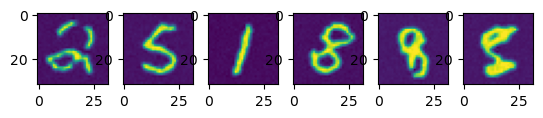

Epoch 10 | Loss: 0.012288703335914761 


 50%|████▉     | 496/1000 [05:01<05:06,  1.64it/s]

In [ ]:
### Training Loop
for epoch in range(epochs):

    epoch_loss = 0
    steps = 0
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        
        loss = ddpm.loss(batch[0].to(device))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        steps += 1

    if epoch % 10 == 0 and epoch != 0:
        samples = ddpm.sample()
        plot_samples(samples)

    if epoch % 25 == 0 and epoch != 0:
        torch.save(unet.state_dict(), os.path.join(models_dir, f"{MODEL}_{epoch}.pth"))

    print(f"Epoch {epoch} | Loss: {epoch_loss / (steps)} ")
